In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.cuda.amp import GradScaler, autocast


In [36]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [37]:
from torch.utils.data import Subset


# Data transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomCrop(32, padding=4),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using dataset statistics
])

# Load CIFAR-10 dataset with specified transformations
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
print("Done loading initial data")

# Initialize lists to store indices for training and testing samples
train_indices = []
test_indices = []

# Loop through each class (CIFAR-10 has 10 classes)
for class_idx in range(10):
    # Get the indices of samples belonging to the current class in the training and testing datasets
    train_class_indices = np.where(np.array(train_data.targets) == class_idx)[0]
    test_class_indices = np.where(np.array(test_data.targets) == class_idx)[0]

    # Select the first 500 samples for training and 100 samples for testing per class
    train_indices.extend(train_class_indices[:500])
    test_indices.extend(test_class_indices[:100])

# Create subsets using the selected indices
train_data_subset = Subset(train_data, train_indices)  # First 500 training samples per class
test_data_subset = Subset(test_data, test_indices)  # First 100 testing samples per class
print("Created subsets")

# Print the sizes of each subset
print(f"Training subset size: {len(train_data_subset)}")
print(f"Testing subset size: {len(test_data_subset)}")



# Data loaders
train_loader = DataLoader(train_data_subset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data_subset, batch_size=128, shuffle=False, num_workers=4)

# Get the class names
class_names = train_data.classes
print(class_names)


Files already downloaded and verified
Files already downloaded and verified
Done loading initial data
Created subsets
Training subset size: 5000
Testing subset size: 1000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# VG11 Model
---
The following model is trained on 5000 Images (PCA Reduced), 

*You should use the following in your training process unless specified otherwise: cross-entropy loss
torch.nn.CrossEntropyLoss, and optimize using SGD optimizer with momentum=0.9.*

loss function is cross entropy loss and stochastic gradient descent is used as the optimization function.

In [38]:
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            #feature extraction block:
            #layer 1: Convolution + BatchNorm + ReLU + MaxPool
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Input channels=3 for RGB
            # create a convolutional layer that takes an RGB image (3 channels) and extracts 64 features using 3×3 filters
            nn.BatchNorm2d(64), #normalize the 64 feature maps output by the first convolutional layer
            nn.ReLU(inplace=True), #activation funct; add non-linearity (set all negative values to 0) (also this reduces overfitting)
            #inplace=True means the ReLU operation modifies the data in place, saving memory
            nn.MaxPool2d(kernel_size=2, stride=2), #reduce the width and height of the image by half

            # layer 2: 1 Convolution + BatchNorm + ReLU + MaxPool
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Increase features from 64 to 128
            nn.BatchNorm2d(128),  # Normalizes the 128 feature maps
            nn.ReLU(inplace=True),  # Applies non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce spatial dimensions by half

            # layer 3: 2 consecutive convolutional layers + BatchNorm + ReLU + MaxPool
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # First 256-channel convolution
            nn.BatchNorm2d(256),  # Normalizes the 256 feature maps
            nn.ReLU(inplace=True),  # Applies non-linearity
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Second 256-channel convolution
            nn.BatchNorm2d(256),  # Normalizes the 256 feature maps.
            nn.ReLU(inplace=True),  # Applies non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce spatial dimensions by half

            #layer 4: 2 consecutive convolutional layers + BatchNorm + ReLU + MaxPool
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # First 512-channel convolution
            nn.BatchNorm2d(512),  # Normalize the 512 feature maps
            nn.ReLU(inplace=True),  # Apply non-linearity
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # Second 512-channel convolution
            nn.BatchNorm2d(512),  # Normalize the 512 feature maps
            nn.ReLU(inplace=True),  # Applies non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce spatial dimensions by half again

            # layer 5: 2 consecutive convolutional layers + BatchNorm + ReLU + MaxPool
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # First 512-channel convolution
            nn.BatchNorm2d(512),  # Normalizing the 512 feature maps
            nn.ReLU(inplace=True),  # Apply non-linearity
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # 2nd 512-channel convolution
            nn.BatchNorm2d(512),  # normalize the 512 feature maps
            nn.ReLU(inplace=True),  # apply non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2),  # Final pooling, reduce spatial dimensions by half
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x): # data flow through network
        x = self.features(x) # Pass through feature extractor
        x = x.view(x.size(0), -1)  # Flatten before fully connected layers
        x = self.classifier(x) # Pass through classifier
        return x

In [ ]:
# Instantiate the model
model = VGG11().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [ ]:
# Training Function with Mixed Precision

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model weights

        total_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(output, 1)  # Get predicted labels
        correct += (predicted == target).sum().item()  # Count correct predictions
        total += target.size(0)

        # Save predictions and true labels for metric calculations
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')  # Adjust for multiclass
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Return the loss, accuracy, precision, recall, and F1 score
    return total_loss / len(train_loader), accuracy, precision, recall, f1


# Evaluation Function with Mixed Precision
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute loss

            total_loss += loss.item()  # Accumulate loss
            _, predicted = torch.max(output, 1)  # Get predicted labels
            correct += (predicted == target).sum().item()  # Count correct predictions
            total += target.size(0)

            # Save predictions and true labels for metric calculations
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')  # Adjust for multiclass
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Return the loss, accuracy, precision, recall, and F1 score
    return total_loss / len(test_loader), accuracy, precision, recall, f1


In [ ]:
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training Loop
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduces learning rate by factor of 0.1 every 5 epochs

for epoch in range(20):
    model.to(device)  # Ensure model is on the right device

    # train model, calculate train loss and accuracy
    train_loss, train_acc, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device)

    # Evaluate model & calculate test loss and accuracy
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion, device)

    # Print the results for this epoch
    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
        f"Train Precision={train_precision:.4f}, Train Recall={train_recall:.4f}, Train F1={train_f1:.4f}, "
        f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%, "
        f"Test Precision={test_precision:.4f}, Test Recall={test_recall:.4f}, Test F1={test_f1:.4f}"
    )

    # Step the scheduler to adjust the learning rate
    scheduler.step()


# Experiments 
---
## VGGAddedLayer

1. For VG11
Layer Added: Block 6 has been added. This will be used to see if the models performance has any real improvement from the previous Trainign run for VG11.
Layer Removed: Block 5 has been removed to see if the model was overfitting or not.

## Experimenting with different kernel sizes

2. VGG2 and VGG7

In [39]:
import torch.nn.functional as F

# CustomVGG with added layers
class CustomVGGAddedLayer(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomVGGAddedLayer, self).__init__()
         # Feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 6 (Added)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # Additional Conv layer
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            # No MaxPool to prevent feature map size shrinkage to 0x0
        )

        # Classifier with Global Average Pooling
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling to size 1x1
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 512)
        x = self.classifier(x)
        return x


# CustomVGG with removed layers

import torch
import torch.nn as nn

class CustomVGGRemovedLayer(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomVGGRemovedLayer, self).__init__()

        # Reduce number of convolutional layers
        self.features = nn.Sequential(
            # First Convolution Block: 3x32x32 -> 64x32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x16x16

            # Second Convolution Block: 64x16x16 -> 128x16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x8x8

            # Third Convolution Block: 128x8x8 -> 256x8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 256x4x4
        )

        # Fully Connected Layer
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),  # 256 * 4 * 4 is the flattened size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # Pass through convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor (batch_size, 256 * 4 * 4)
        x = self.classifier(x)  # Pass through fully connected layers
        return x



# CustomVGG with kernel 2x2
class CustomVGG2(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomVGG2, self).__init__()

        # Define the original VGG architecture with 2x2 kernels
        # VGG layers with 2x2 kernels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=2, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, padding=1)

        # MaxPool2d layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the flattened layer based on input size (32x32 for CIFAR-10)
        self.fc_input_size = 512 * 1 * 1  # After 5 convolutional layers and pooling, CIFAR-10 images (32x32) get reduced to 1x1

        # Define fully connected layers (same as original VGG)
        self.fc1 = nn.Linear(self.fc_input_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)  # Output layer

    def forward(self, x):
        # Apply convolutional layers with ReLU activation
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.pool(torch.relu(self.conv5(x)))

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(-1, self.fc_input_size)  # Flatten to (batch_size, 512*1*1)

        # Apply fully connected layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Final output layer

        return x

# CustomVGG with kernel 7x7

class CustomVGG7(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomVGG7, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),  # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3),  # 16x16 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=7, stride=1, padding=3),  # 8x8 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
            nn.Conv2d(256, 512, kernel_size=7, stride=1, padding=3),  # 4x4 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4 -> 2x2
            nn.Conv2d(512, 512, kernel_size=7, stride=1, padding=3),  # 2x2 -> 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2 -> 1x1
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        # Apply weight initialization
        self.apply(self.weight_init)

    def forward(self, x):
        # Apply feature extraction
        x = self.features(x)

        # Flatten the tensor to match the input size for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 512)

        # Apply classifier layers
        x = self.classifier(x)

        return x

    def weight_init(self, m):
        """Initialize weights using He initialization (kaiming)"""
        if isinstance(m, nn.Conv2d):
            # He initialization for Conv2D layers
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Initialize biases to 0
        elif isinstance(m, nn.Linear):
            # He initialization for Linear layers
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Initialize biases to 0
        # No initialization for ReLU layers, as they have no weights/biases



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def train_variant(model, train_loader, criterion, optimizer, device):
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(train_loader)
    acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0  # This handles the zero-division warning
    )

    return avg_loss, acc, precision, recall, f1

def evaluate_variant(model, test_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(test_loader)
    acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0  # This handles the zero-division warning
    )

    return avg_loss, acc, precision, recall, f1


In [ ]:
import torch.optim as optim

# Training Loop for customVGGAddedLayerModel
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduces learning rate by factor of 0.1 every 5 epochs

# Loop over epochs
for epoch in range(10):
    # Ensure model is on the right device, initializing it only once before training starts
    customVGGAddedLayerModel = CustomVGGAddedLayer(num_classes=10).to(device)

    # Train model, calculate train loss and accuracy, and other metrics
    # Ensure the model is in training mode
    customVGGAddedLayerModel.train()
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_variant(
        customVGGAddedLayerModel, train_loader, criterion, optimizer, device
    )

    # Evaluate model & calculate test loss and accuracy, and other metrics
    # Ensure the model is in evaluation mode
    customVGGAddedLayerModel.eval()
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_variant(
        customVGGAddedLayerModel, test_loader, criterion, device
    )

    # Print the results for this epoch
    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Train Precision={train_precision:.2f}, "
        f"Train Recall={train_recall:.2f}, Train F1={train_f1:.2f}, "
        f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%, Test Precision={test_precision:.2f}, "
        f"Test Recall={test_recall:.2f}, Test F1={test_f1:.2f}"
    )

    # Step the scheduler to adjust the learning rate at the end of the epoch
    scheduler.step()


In [ ]:
# Training Loop for CustomVGGRemovedLayer Model
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduces learning rate by factor of 0.1 every 5 epochs

for epoch in range(10):
    customVGGRemovedLayerModel = CustomVGGRemovedLayer(num_classes=10).to(device)
    customVGGRemovedLayerModel.to(device)  # Ensure model is on the right device

    # Train model, calculate train loss and accuracy, and other metrics
    # Modify the train() function to return all necessary values
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_variant(customVGGRemovedLayerModel, train_loader, criterion, optimizer, device)

    # Evaluate model & calculate test loss and accuracy, and other metrics
    # Modify the evaluate() function to return all necessary values
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_variant(customVGGRemovedLayerModel, test_loader, criterion, device)

    # Print the results for this epoch
    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Train Precision={train_precision:.2f}, "
        f"Train Recall={train_recall:.2f}, Train F1={train_f1:.2f}, "
        f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%, Test Precision={test_precision:.2f}, "
        f"Test Recall={test_recall:.2f}, Test F1={test_f1:.2f}"
    )
    scheduler.step()  # Step the scheduler to adjust the learning rate

In [ ]:
# Training Loop for CustomVGG2
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduces learning rate by factor of 0.1 every 5 epochs

for epoch in range(10):
    customVGG2Model = CustomVGG2(num_classes=10).to(device)
    customVGG2Model.to(device)  # Ensure model is on the right device

    # train model, calculate train loss and accuracy, and other metrics
    # Modify the train() function to return all necessary values
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_variant(customVGG2Model, train_loader, criterion, optimizer, device)

    # Evaluate model & calculate test loss and accuracy, and other metrics
    # Modify the evaluate() function to return all necessary values
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_variant(customVGG2Model, test_loader, criterion, device)

    # Print the results for this epoch
    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Train Precision={train_precision:.2f}, "
        f"Train Recall={train_recall:.2f}, Train F1={train_f1:.2f}, "
        f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%, Test Precision={test_precision:.2f}, "
        f"Test Recall={test_recall:.2f}, Test F1={test_f1:.2f}"
    )
    # Print the results for this epoch
    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
        f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%"
    )
    scheduler.step()  # Step the scheduler to adjust the learning rate


In [ ]:
# Training Loop for CustomVGG7
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduces learning rate by factor of 0.1 every 5 epochs

for epoch in range(10):
    customVGG7Model = CustomVGG7(num_classes=10).to(device)
    customVGG7Model.to(device)  # Ensure model is on the right device

    train_loss, train_acc, train_precision, train_recall, train_f1 = train_variant(
        customVGG7Model, train_loader, criterion, optimizer, device
    )

    # Evaluate model & calculate test loss and accuracy, and other metrics
    # Ensure the model is in evaluation mode
    customVGG7Model.eval()
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_variant(
        customVGG7Model, test_loader, criterion, device
    )

    # Print the results for this epoch
    print(
        f"Epoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Train Precision={train_precision:.2f}, "
        f"Train Recall={train_recall:.2f}, Train F1={train_f1:.2f}, "
        f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%, Test Precision={test_precision:.2f}, "
        f"Test Recall={test_recall:.2f}, Test F1={test_f1:.2f}"
    )
    scheduler.step()  # Step the scheduler to adjust the learning rate


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to generate the confusion matrix
def generate_confusion_matrix(model, test_loader, device):
    model.eval()
    all_preds = []  # List to store all predictions
    all_labels = []  # List to store all true labels

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Append the predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = [str(i) for i in range(10)]  # Class names for CIFAR-10 (0-9)
cm = generate_confusion_matrix(model, test_loader, device)
plot_confusion_matrix(cm, class_names)


In [ ]:
cm2 = generate_confusion_matrix(customVGGAddedLayerModel, test_loader, device)
plot_confusion_matrix(cm2, class_names)

In [ ]:
cm3 = generate_confusion_matrix(customVGGRemovedLayerModel, test_loader, device)
plot_confusion_matrix(cm3, class_names)

In [ ]:
cm4 = generate_confusion_matrix(customVGG2Model, test_loader, device)
plot_confusion_matrix(cm4, class_names)


In [ ]:
cm5 = generate_confusion_matrix(customVGG7Model, test_loader, device)
plot_confusion_matrix(cm5, class_names)

In [ ]:
# Save the trained model and optimizer
def save_model(model, optimizer, model_name="model_name.pth"):
    # Save the state dictionaries for the model and optimizer
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, model_name)
    print(f"Model saved to {model_name}")


# Save the models


In [ ]:
save_model(model, optimizer, "base_model.pth")
save_model(customVGGAddedLayerModel, optimizer, "added_layer_model.pth")
save_model(customVGGRemovedLayerModel, optimizer, "removed_layer_model.pth")
save_model(customVGG2Model, optimizer, "custom2x2_kernel_model.pth")
save_model(customVGG7Model, optimizer, "custom7x7_kernel_model.pth")


# For the instructor
---

1. Load the model classes above - VG11, CustomVGGAddedLayer, CustomVGGRemovedLayer, CustomVGG2, CustomVGG7
2. 

In [40]:
import torch
import torch.optim as optim

def load_model(model_class, *model_args, model_name="model_name.pth"):
    # Create an instance of the model architecture
    model = model_class(*model_args)

    # Initialize an optimizer for the model's parameters
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Load the checkpoint
    checkpoint = torch.load(model_name)

    # Filter incompatible keys during model state dict loading
    model_state = checkpoint['model_state_dict']
    model.load_state_dict(model_state, strict=False)

    # Load optimizer state if possible
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except ValueError:
        print(f"Warning: Optimizer state mismatch for {model_name}. Skipping optimizer state loading.")

    # Move model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    print(f"Model loaded from {model_name}")
    return model, optimizer




In [41]:
# Define input and architecture parameters used during training
input_size = 50  # For PCA-reduced input
hidden_size1 = 512
hidden_size2 = 512
output_size = 10  # Number of classes in CIFAR-10

# Define an optimizer instance
# optimizer = optim.SGD([], lr=0.01, momentum=0.9)  # Parameters will be loaded

# Load each model and its optimizer if needed

num_classes = 10  # CIFAR-10 has 10 classes

# Load each model and its optimizer using the updated load_model function
base_model, base_optimizer = load_model(VGG11, num_classes, model_name="base_model.pth")
added_layer_model, added_layer_optimizer = load_model(CustomVGGAddedLayer, num_classes, model_name="added_layer_model.pth")
removed_layer_model, removed_layer_optimizer = load_model(CustomVGGRemovedLayer, num_classes, model_name="removed_layer_model.pth")
custom2x2_kernel_model, custom2x2_kernel_optimizer = load_model(CustomVGG2, num_classes, model_name="custom2x2_kernel_model.pth")
custom7x7_kernel_model, custom7x7_kernel_optimizer = load_model(CustomVGG7, num_classes, model_name="custom7x7_kernel_model.pth")



Model loaded from base_model.pth
Model loaded from added_layer_model.pth
Model loaded from removed_layer_model.pth
Model loaded from custom2x2_kernel_model.pth
Model loaded from custom7x7_kernel_model.pth


# To import `test_loader`, run the above kernel from the begininng to cell 3.

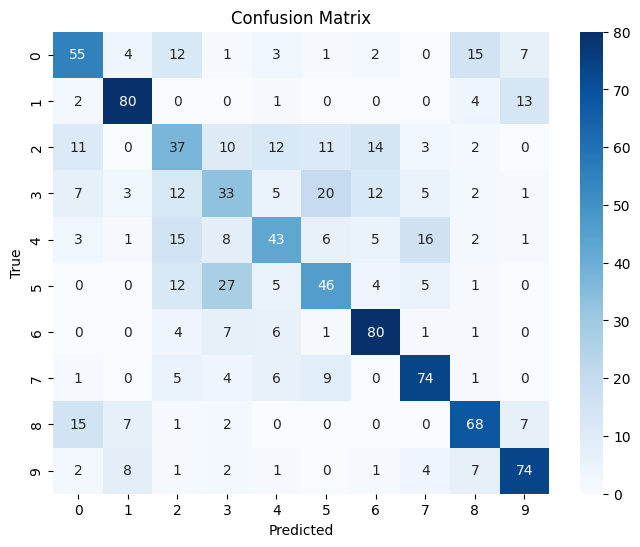

In [42]:
class_names = [str(i) for i in range(10)]  # Class names for CIFAR-10 (0-9)
cm = generate_confusion_matrix(base_model, test_loader, device)
plot_confusion_matrix(cm, class_names)

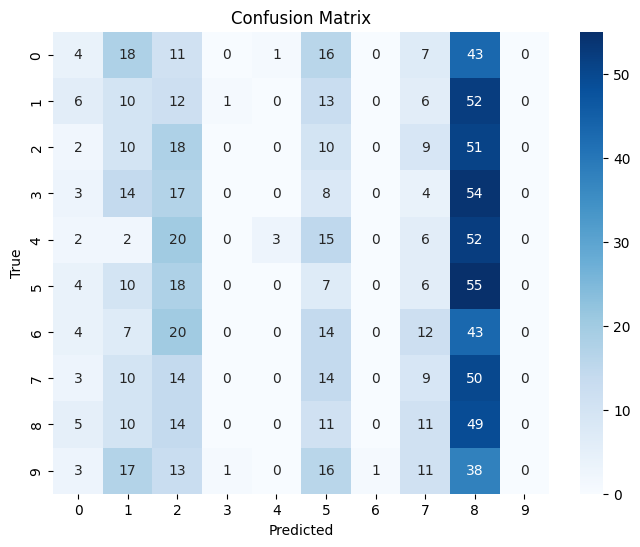

In [43]:
cm2 = generate_confusion_matrix(added_layer_model, test_loader, device)

plot_confusion_matrix(cm2, class_names)

In [ ]:

cm3 = generate_confusion_matrix(removed_layer_model, test_loader, device)
plot_confusion_matrix(cm3, class_names)

In [ ]:


cm4 = generate_confusion_matrix(custom2x2_kernel_model, test_loader, device)
plot_confusion_matrix(cm4, class_names)

In [ ]:
cm5 = generate_confusion_matrix(custom7x7_kernel_model, test_loader, device)
plot_confusion_matrix(cm5, class_names)
